In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import joblib


# Data loading and preprocessing

In [3]:
df=pd.read_csv("dataset/train_set_rec.csv",nrows=15000)
print(df.head())
print(df.info())


             Timestamp  KPI_Value  Status                   KPI_Name
0  2017-04-30 16:00:00   1.901639       0  Stamping Press Efficiency
1  2017-04-30 16:01:00   1.786885       0  Stamping Press Efficiency
2  2017-04-30 16:02:00   2.000000       0  Stamping Press Efficiency
3  2017-04-30 16:03:00   1.885246       0  Stamping Press Efficiency
4  2017-04-30 16:04:00   1.819672       0  Stamping Press Efficiency
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  15000 non-null  object 
 1   KPI_Value  15000 non-null  float64
 2   Status     15000 non-null  int64  
 3   KPI_Name   15000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 468.9+ KB
None


In [4]:
# convert timestamp to datetime make it index 
df.index = pd.to_datetime(df['Timestamp'] )
df.drop('Timestamp', axis=1, inplace=True)
df.sort_index(inplace=True)

In [5]:
# Normaliser
scaler = MinMaxScaler()
df['KPI_Value'] = scaler.fit_transform(df['KPI_Value'].values.reshape(-1,1))

In [6]:
# KPI_name to label encoding
label_encoder = LabelEncoder()
df['KPI_Name'] = label_encoder.fit_transform(df['KPI_Name'])
# save the encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

C:\Users\E15\AppData\Local\Temp\ipykernel_25180\3664052485.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['KPI_Value'], shade=True, color='b')


<Axes: xlabel='KPI_Value', ylabel='Density'>

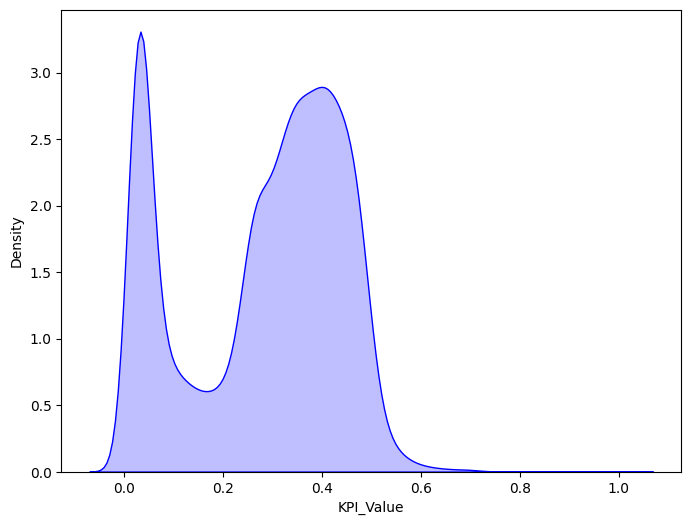

In [7]:
# plot the distribution of KPI values
plt.figure(figsize=(8, 6))
sns.kdeplot(df['KPI_Value'], shade=True, color='b')

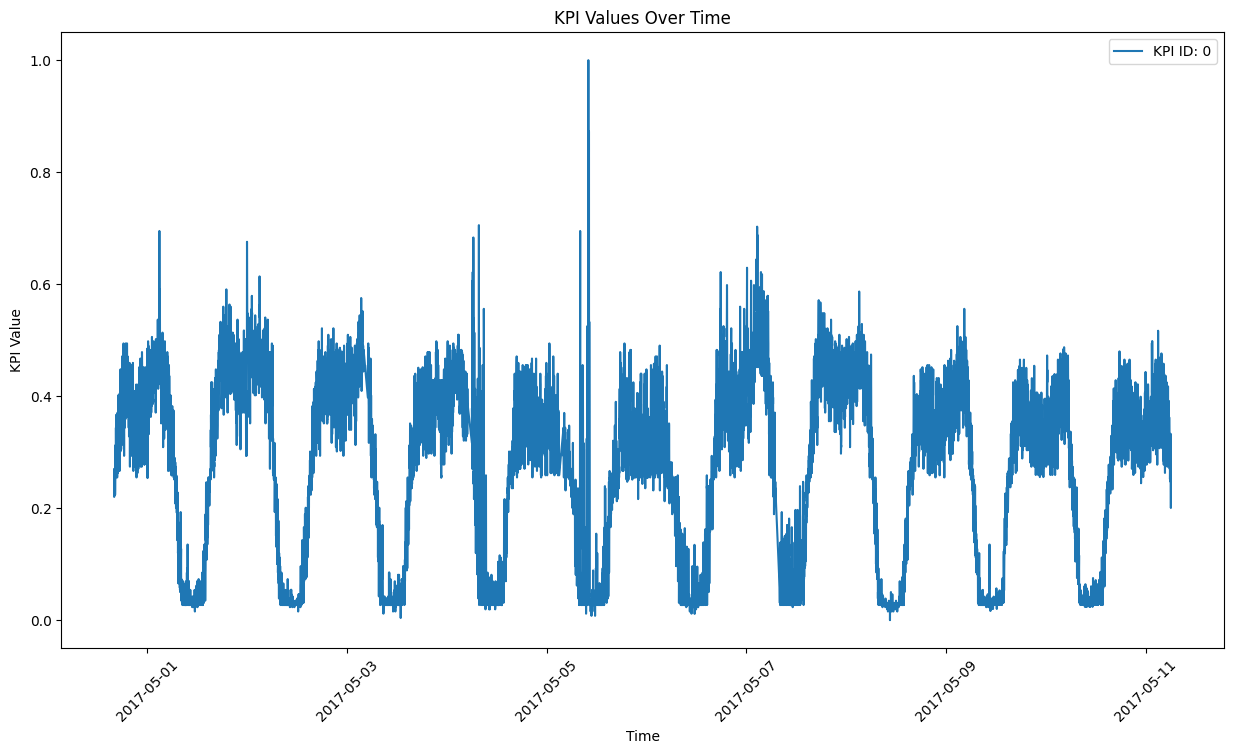

In [8]:
# Plot scaled KPI values over time for each KPI ID
unique_kpis = df['KPI_Name'].unique()

plt.figure(figsize=(15, 8))

for kpi in unique_kpis:
    plt.plot(df[df['KPI_Name'] == kpi].index, df[df['KPI_Name'] == kpi]['KPI_Value'], label=f'KPI ID: {kpi}')

plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('KPI Values Over Time')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

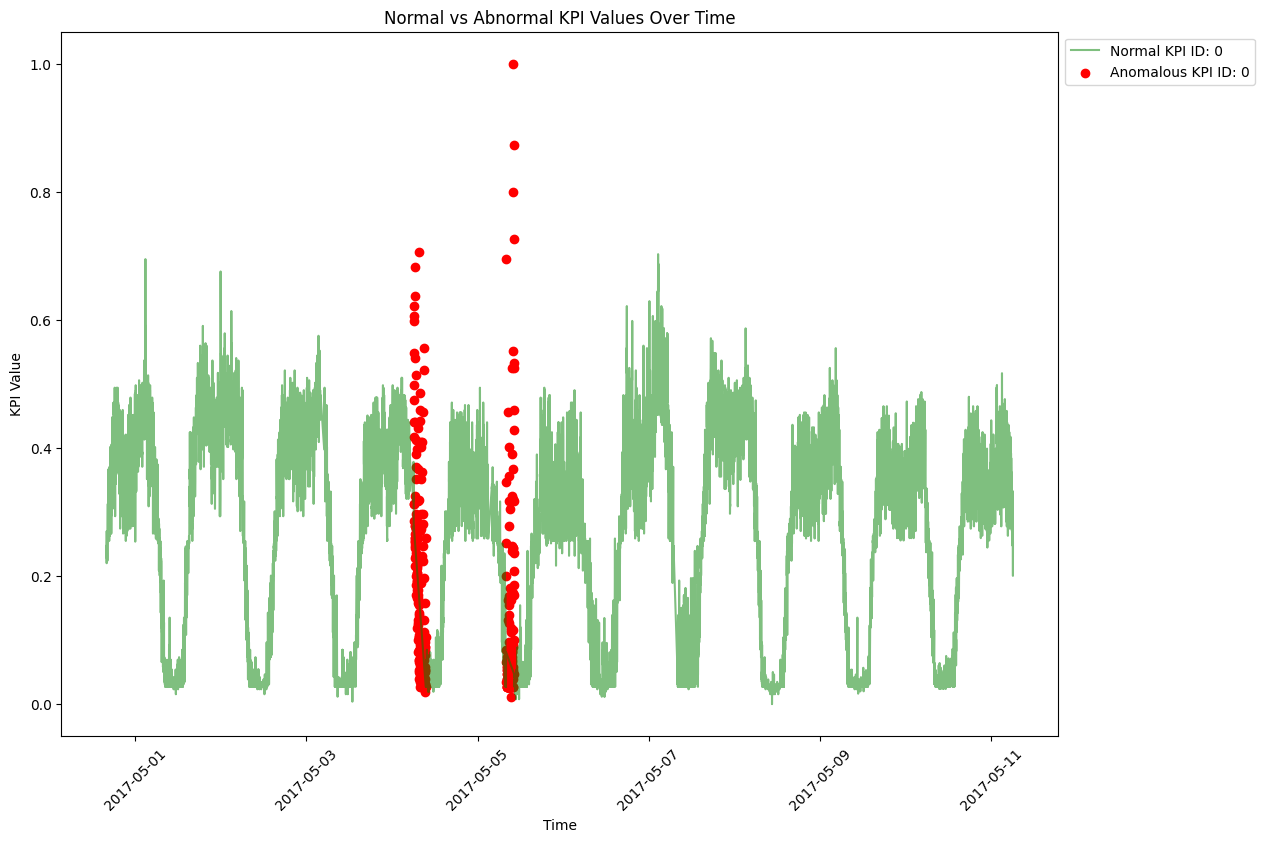

In [9]:
# Separate normal and abnormal data points
normal_data = df[df['Status'] == 0]
abnormal_data = df[df['Status'] == 1]

# Plot normal and abnormal points
plt.figure(figsize=(15, 8))


for kpi in df['KPI_Name'].unique():
    plt.plot(normal_data[normal_data['KPI_Name'] == kpi].index, 
             normal_data[normal_data['KPI_Name'] == kpi]['KPI_Value'], 
             label=f'Normal KPI ID: {kpi}', color='green', alpha=0.5)
    
    plt.scatter(abnormal_data[abnormal_data['KPI_Name'] == kpi].index, 
                abnormal_data[abnormal_data['KPI_Name'] == kpi]['KPI_Value'], 
                label=f'Anomalous KPI ID: {kpi}', color='red')
    
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('Normal vs Abnormal KPI Values Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=45)
plt.show()


# Feature Engineering

In [10]:
# Création de lags, rolling mean, rolling std, seasonal lags et différences
for lag in [1, 3, 5, 12]:  # Lags saisonniers (ex. 12 pour mensuel si applicable)
    df[f'lag_{lag}'] = df['KPI_Value'].shift(lag)
    
for window in [3, 5, 7]:
    df[f'rolling_mean_{window}'] = df['KPI_Value'].rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['KPI_Value'].rolling(window=window).std()

# Différences pour capturer les changements dans les KPI
df['KPI_diff'] = df['KPI_Value'].diff()
df.dropna(inplace=True)

# Application du clustering pour détecter des groupes de KPI similaires
kmeans = KMeans(n_clusters=5, random_state=42)  # Ajustez le nombre de clusters si nécessaire
df['KPI_Cluster'] = kmeans.fit_predict(df[['KPI_Value', 'KPI_diff', 'rolling_mean_3', 'rolling_std_3']])
# save kmeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


['kmeans_model.pkl']

In [11]:
df

,KPI_Value,Status,KPI_Name,lag_1,lag_3,lag_5,lag_12,rolling_mean_3,rolling_std_3,rolling_mean_5,rolling_std_5,rolling_mean_7,rolling_std_7,KPI_diff,KPI_Cluster
Timestamp,,,,,,,,,,,,,,,
2017-04-30 16:12:00,0.247104,0,0,0.258687,0.258687,0.254826,0.247104,0.254826,0.006687,0.257143,0.005856,0.254826,0.007049,-0.011583,4
2017-04-30 16:13:00,0.254826,0,0,0.247104,0.258687,0.262548,0.220077,0.253539,0.005898,0.255598,0.005034,0.256481,0.004913,0.007722,4
2017-04-30 16:14:00,0.223938,0,0,0.254826,0.258687,0.258687,0.270270,0.241956,0.016075,0.248649,0.014601,0.252068,0.013322,-0.030888,4
2017-04-30 16:15:00,0.231660,0,0,0.223938,0.247104,0.258687,0.243243,0.236808,0.016075,0.243243,0.014954,0.247656,0.014348,0.007722,4
2017-04-30 16:16:00,0.250965,0,0,0.231660,0.254826,0.258687,0.227799,0.235521,0.013921,0.241699,0.013263,0.246553,0.013638,0.019305,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-11 06:01:00,0.273950,0,0,0.332831,0.255550,0.308258,0.321791,0.296030,0.032082,0.278224,0.033426,0.279750,0.030901,-0.058880,4
2017-05-11 06:02:00,0.262910,0,0,0.273950,0.281310,0.247478,0.273950,0.289897,0.037589,0.281310,0.030458,0.280327,0.030481,-0.011040,4
2017-05-11 06:03:00,0.233470,0,0,0.262910,0.332831,0.255550,0.251870,0.256777,0.020925,0.276894,0.036188,0.269643,0.032122,-0.029440,4


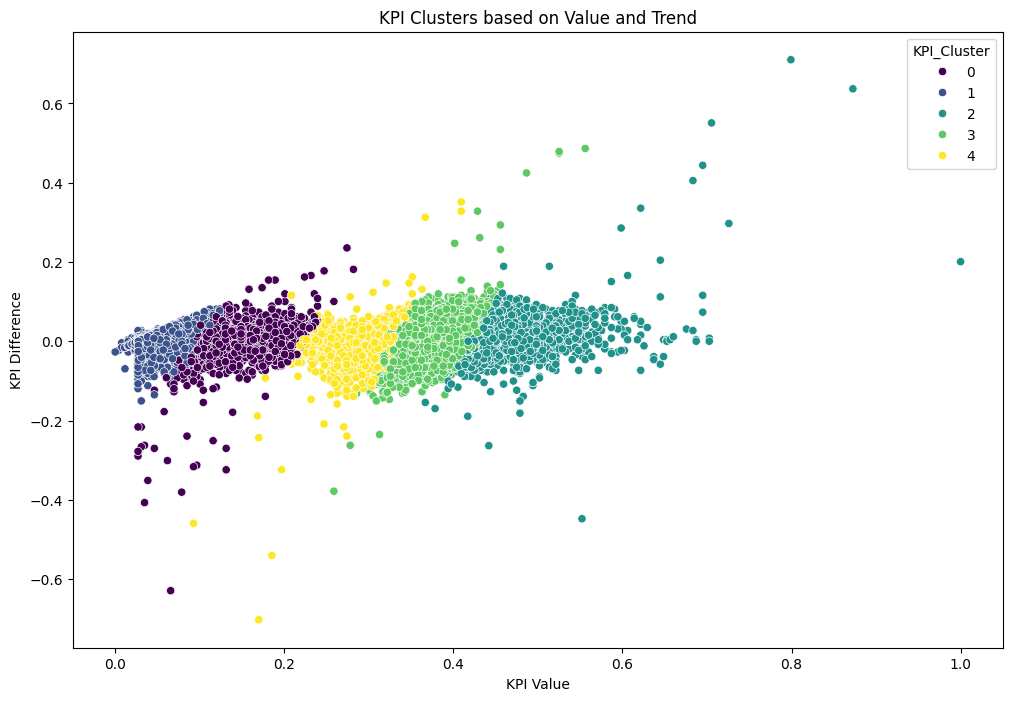

In [12]:
# Visualisation des clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='KPI_Value', y='KPI_diff', hue='KPI_Cluster', palette='viridis')
plt.title('KPI Clusters based on Value and Trend')
plt.xlabel('KPI Value')
plt.ylabel('KPI Difference')
plt.show()

# Time Series

In [13]:
def create_windowed_data(df, window_size, target_column='Status'):
    X, y = [], []
    for i in range(window_size, len(df)):
        features = df.iloc[i-window_size:i].drop(columns=['Status', 'KPI_Value']).values
        X.append(features)
        y.append(df.iloc[i][target_column])
    return np.array(X), np.array(y)

In [14]:
window_size = 10
X, y = create_windowed_data(df, window_size=window_size)
print(f'Shape of X: {X.shape}, Shape of y: {y.shape}')

Shape of X: (14978, 10, 13), Shape of y: (14978,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f'Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}')

Shape of X_train: (11982, 10, 13), Shape of X_test: (2996, 10, 13)
Shape of y_train: (11982,), Shape of y_test: (2996,)


In [16]:
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
regressor= XGBRegressor()

forecaster = ForecasterAutoreg(
    regressor=regressor,
    lags=window_size
)

In [17]:
# fit the model
exog = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
print(exog.shape)
forecaster.fit(y=pd.Series(y_train), exog=exog)

(11982, 130)


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [18]:
# Adjust the index of exog_test to start from the appropriate value
exog_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
exog_test.index = range(len(X_train), len(X_train) + len(X_test))
y_pred = forecaster.predict(steps=len(y_test), exog=exog_test)

In [19]:
# Calculate F1 Score
# Convert predictions into binary anomaly labels based on threshold
threshold = 1  # Adjust threshold as necessary
y_pred_anomalies = [1 if abs(pred) > threshold else 0 for pred in y_pred]
f1 = f1_score(y_test, y_pred_anomalies)
f1

c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

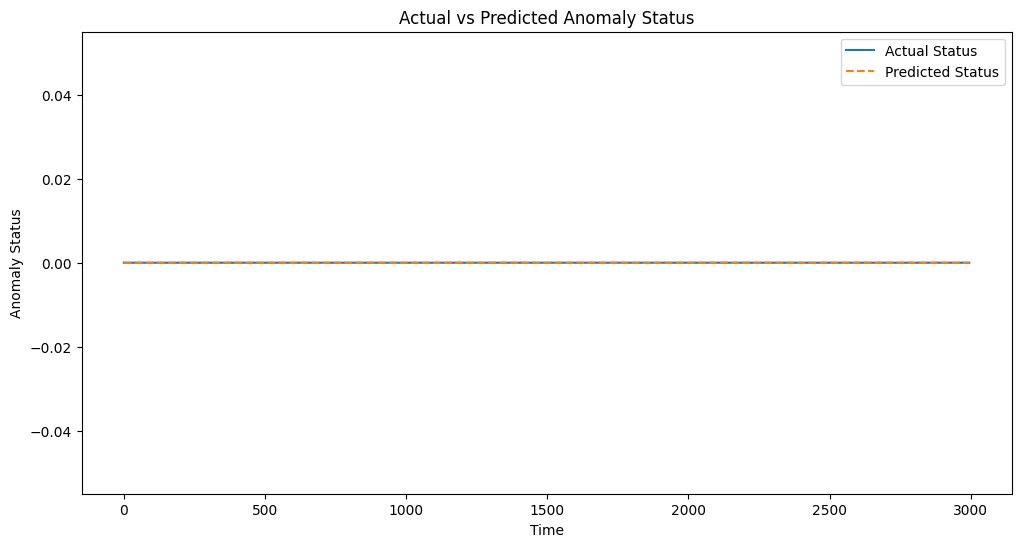

In [20]:
# Visualize Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Status')
plt.plot(y_pred_anomalies, label='Predicted Status', linestyle='dashed')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Anomaly Status")
plt.title("Actual vs Predicted Anomaly Status")
plt.show()

In [21]:
# Define a custom metric function for F1 score
def custom_f1_score(y_true, y_pred):
    threshold = 1  # Adjust threshold as necessary
    y_pred_anomalies = [1 if abs(pred) > threshold else 0 for pred in y_pred]
    return f1_score(y_true, y_pred_anomalies)

# Define backtesting function
metrics, backtest_predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=pd.Series(y),
    initial_train_size=int(len(y) * 0.8),
    exog=pd.DataFrame(X.reshape(X.shape[0], -1)),
    steps=5,  # Number of steps to predict in each iteration
    metric=custom_f1_score,
    refit=True
)

c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:475: LongTrainingWarning: The forecaster will be fit 600 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/600 [00:00<?, ?it/s]

c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
backtest_predictions['Predicted_Anomalies'] = backtest_predictions['pred'].apply(
    lambda pred: 1 if abs(pred) > threshold else 0
)
backtest_f1 = f1_score(y[int(len(y) * 0.8):], backtest_predictions['Predicted_Anomalies'])
print(f'Backtest F1 Score: {backtest_f1}')

Backtest F1 Score: 0.0


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


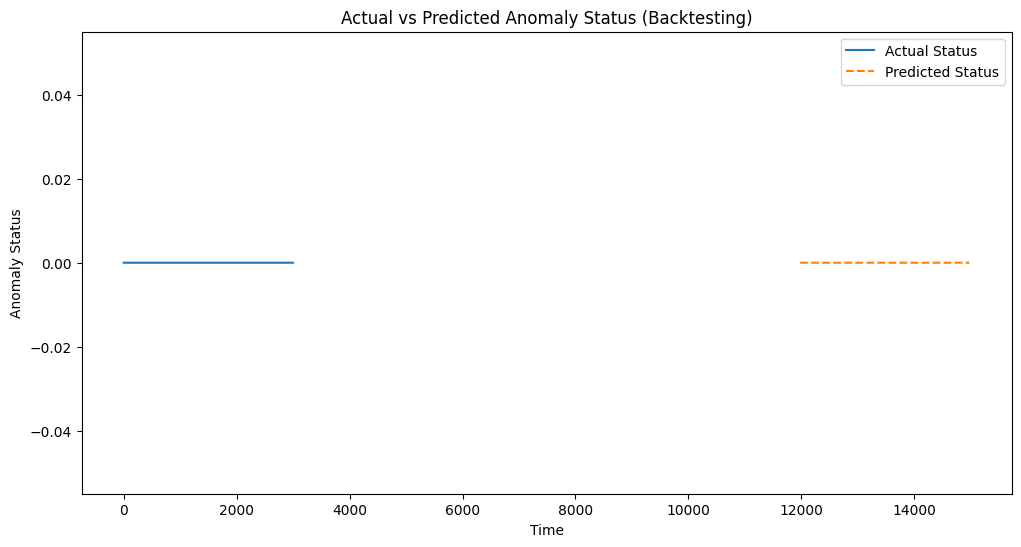

In [23]:
# Plot Actual vs Backtested Predictions
plt.figure(figsize=(12, 6))
plt.plot(y[int(len(y)*0.8):], label='Actual Status')
plt.plot(backtest_predictions['Predicted_Anomalies'], label='Predicted Status', linestyle='dashed')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Anomaly Status")
plt.title("Actual vs Predicted Anomaly Status (Backtesting)")
plt.show()

In [24]:
import pickle

# save the best model
with open('model.pkl', 'wb') as f:
	pickle.dump(forecaster, f)

In [25]:
# Exemple de données en temps réel
import pandas as pd
import joblib

real_time_data = pd.DataFrame({
    'Timestamp': ['2017-04-30 16:00:00'],
    'KPI_Value': [1.90163934231],
    'Status': [0],
    'KPI_Name': ['Stamping Press Efficiency']
})

# Convert Timestamp to datetime if not already
real_time_data['Timestamp'] = pd.to_datetime(real_time_data['Timestamp'])
real_time_data.set_index('Timestamp', inplace=True)

# load the label encoder
label_encoder = joblib.load('label_encoder.pkl')
df['KPI_Name'] = label_encoder.fit_transform(df['KPI_Name'])

# Normalisation de KPI_Value
real_time_data['KPI_Value'] = scaler.transform(real_time_data[['KPI_Value']])

# Création des décalages (lags) dans real_time_data
for lag in [1, 3, 5, 12]:
    real_time_data[f'lag_{lag}'] = real_time_data['KPI_Value'].shift(lag)

# Calculate rolling statistics
real_time_data['rolling_mean_3'] = real_time_data['KPI_Value'].rolling(window=3).mean()
real_time_data['rolling_std_3'] = real_time_data['KPI_Value'].rolling(window=3).std()

# Calculate the difference
real_time_data['KPI_diff'] = real_time_data['KPI_Value'].diff().fillna(0)  # Fill NaN for the first row

# Predict the KPI Cluster
kmeans = joblib.load('kmeans_model.pkl')
KPI_Cluster = kmeans.predict(real_time_data[['KPI_Value', 'KPI_diff', 'rolling_mean_3', 'rolling_std_3']].fillna(0))[0]

c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [26]:
# Remplissage des NaN par 0 pour éviter la perte de la ligne unique
real_time_data.fillna(0, inplace=True)

# Créer `exog_real_time` avec exactement le même nombre de colonnes que `X_train`
num_features = 130  # Remplacez par le nombre correct de caractéristiques

# Initialisez `exog_real_time` avec des zéros
exog_real_time = pd.DataFrame(np.zeros((1, num_features)))

# Remplissez `exog_real_time` avec les valeurs de `real_time_data`
for idx, col in enumerate(real_time_data.columns):
    if idx < num_features:  # Assurez-vous de ne pas dépasser le nombre de caractéristiques
        exog_real_time.iloc[0, idx] = real_time_data[col].values[0]

# Alignez l'index de `exog_real_time` pour qu'il commence à l'index approprié
exog_real_time.index = [11982]  # L'index doit commencer juste après `last_window`



In [29]:
# Charger le modèle
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Assurez-vous que KPI_Name est correctement encodé
# Refit the label encoder with all possible values if necessary
all_possible_kpi_names = df['KPI_Name'].unique().tolist() + real_time_data['KPI_Name'].unique().tolist()
# save all kpi names in a json file
joblib.dump(all_possible_kpi_names, 'all_possible_kpi_names.pkl')

label_encoder.fit(all_possible_kpi_names)
real_time_data['KPI_Name'] = label_encoder.transform(real_time_data['KPI_Name'])

# Remplissage des NaN par 0 pour éviter la perte de la ligne unique
real_time_data.fillna(0, inplace=True)

# Créer `exog_real_time` avec exactement le même nombre de colonnes que `X_train`
num_features = 130  # Remplacez par le nombre correct de caractéristiques

# Initialisez `exog_real_time` avec des zéros
exog_real_time = pd.DataFrame(np.zeros((1, num_features)))

# Remplissez `exog_real_time` avec les valeurs de `real_time_data`
for idx, col in enumerate(real_time_data.columns):
    if idx < num_features:  # Assurez-vous de ne pas dépasser le nombre de caractéristiques
        exog_real_time.iloc[0, idx] = real_time_data[col].values[0]

# Alignez l'index de `exog_real_time` pour qu'il commence à l'index approprié
exog_real_time.index = [11982]  # L'index doit commencer juste après `last_window`

# Prédiction pour 1 pas de temps
y_pred = model.predict(steps=1, exog=exog_real_time)

# Afficher la prédiction
print("Predicted Values:", y_pred)

# Détection d'anomalie avec le seuil
threshold = 1  # Ajuster le seuil si nécessaire

# Vérifiez si y_pred est une série ou un tableau et accédez à la valeur correctement
if isinstance(y_pred, pd.Series):
    anomaly_status = 1 if abs(y_pred.iloc[0]) > threshold else 0  # Utilisez iloc pour accéder à la série
else:
    anomaly_status = 1 if abs(y_pred[0]) > threshold else 0  # Si c'est un tableau NumPy

print("Anomaly Status:", anomaly_status)

Predicted Values: 11982    0.000004
Name: pred, dtype: float64
Anomaly Status: 0


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\utils\utils.py:1260: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
